## GSE202537 – Diurnal alterations in gene expression across striatal subregions in psychosis

- https://pubmed.ncbi.nlm.nih.gov/36302706/

In [3]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import PCA_func as pc
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import normalize

### Step 1: Open the dataset

In [4]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE202537_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=normalize(adata.X, axis=0)*1000000, columns=adata.var.index, index=adata.obs.index).T

#Look at sampeles features
adata.var[['time', 'age', 'sex', 'tissue', 'race', 'subject', 'pmi', 'disease', 'seqid', 'libsize', 'rin', 'bmi', 'ph', 'proc_time', 'death']]
adata.var['time'] = adata.var['time'].astype(float) % 24
adata.var['time']

GSM6123790     8.797414
GSM6123791     7.260858
GSM6123792     1.099309
GSM6123793     1.688509
GSM6123794     4.839043
                ...    
GSM6124000    23.835956
GSM6124001    14.415941
GSM6124002     7.853629
GSM6124003    19.211012
GSM6124004     6.776583
Name: time, Length: 215, dtype: float64

### Step 2: Prepare the dataset

In [5]:
data_df_log = np.log10(data_df + 0.1) #Logarithmic transformation

### Step 3: Exploratory analysis

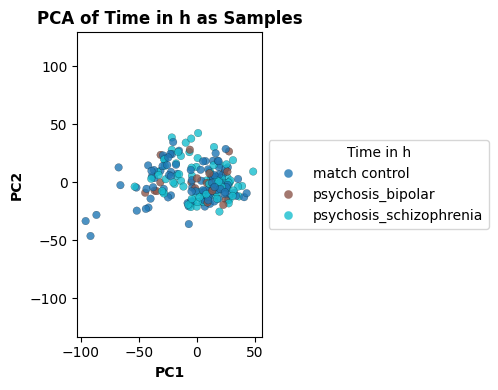

In [6]:
data_df_log_time = data_df_log.join(adata.var['disease']).reset_index().set_index('disease').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Time in h', c_map='tab10')

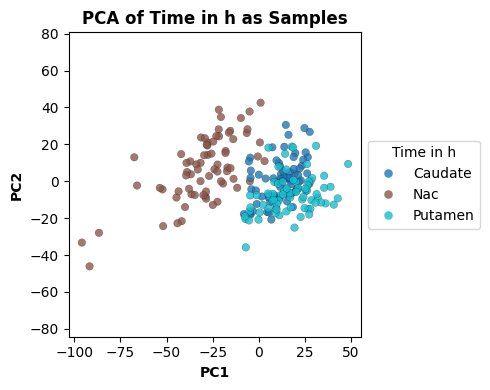

In [7]:
data_df_log_time = data_df_log.join(adata.var['tissue']).reset_index().set_index('tissue').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Time in h', c_map='tab10')

### Step 4: Identify mean and std threshold values

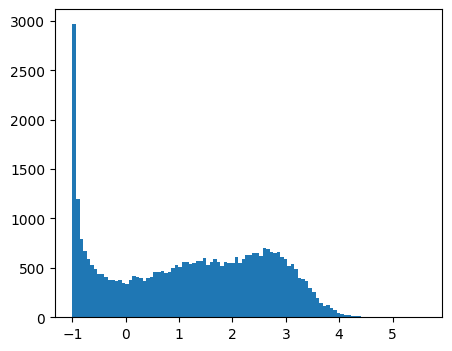

In [8]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.mean(), bins=100);

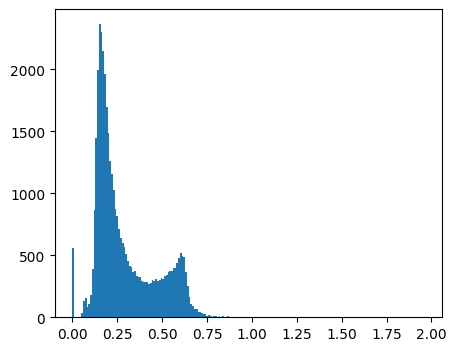

In [9]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.std(), bins=200);

### Step 5: Potential Batch Correction

In [10]:
residual_0 = pc.residual_dummy(data=data_df_log.T[data_df_log.mean()>0].T, data_dummy_1=adata.var['age'], columns=['age'])
residual_1 = pc.residual_dummy(data=residual_0, data_dummy_1=adata.var['sex'], columns=['sex'])
residual_2 = pc.residual_dummy(data=residual_1, data_dummy_1=adata.var['race'], columns=['race'])
residual_3 = pc.residual_dummy(data=residual_2, data_dummy_1=adata.var['bmi'], columns=['bmi'])
residual_4 = pc.residual_dummy(data=residual_3, data_dummy_1=adata.var['ph'], columns=['ph'])
residual_5 = pc.residual_dummy(data=residual_4, data_dummy_1=adata.var['rin'], columns=['rin'])


### Step 6: COFE

### COFE Control Nac

In [13]:
X_train_a = data_df_log[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Nac')]
true_time_train_a = adata.var[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Nac')]['time'].astype(float)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=0, scaling_threshold=3.5)
X_train_a.shape # (Samples, Transcripts)

(36, 5180)

In [14]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1, restarts=10)

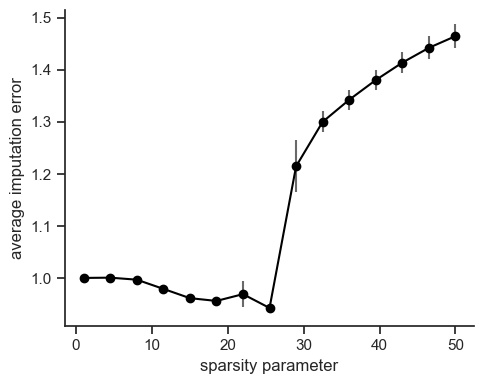

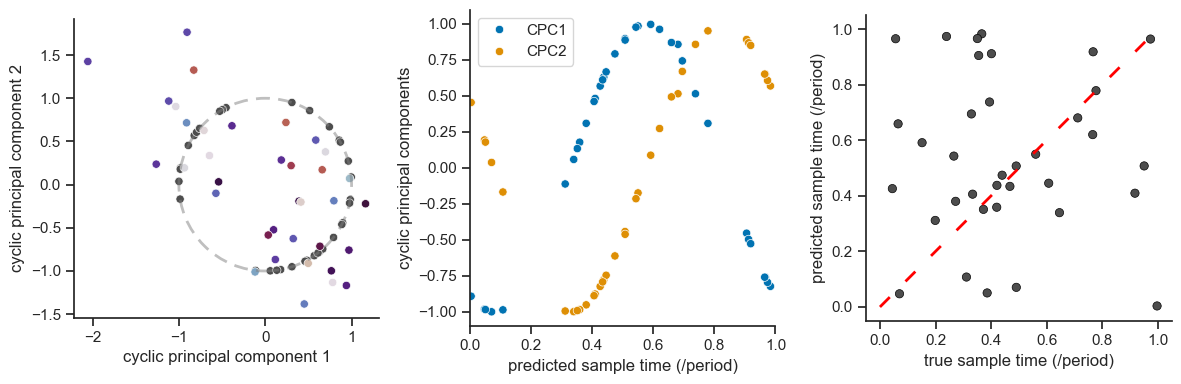

In [15]:
results_train_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=24)

In [16]:
results_train_a["MAPE"]*24

np.float64(3.7594585689123936)

### COFE Control Caudate

In [18]:
X_train_b = data_df_log[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Caudate')]
true_time_train_b = adata.var[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Caudate')]['time'].astype(float)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col', 
                                                                           mean_threshold= 1,scaling_threshold=7)
X_train_b.shape # (Samples, Transcripts)

(36, 6057)

In [19]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1, restarts=10)

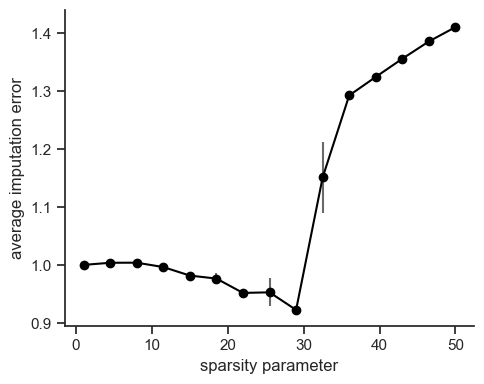

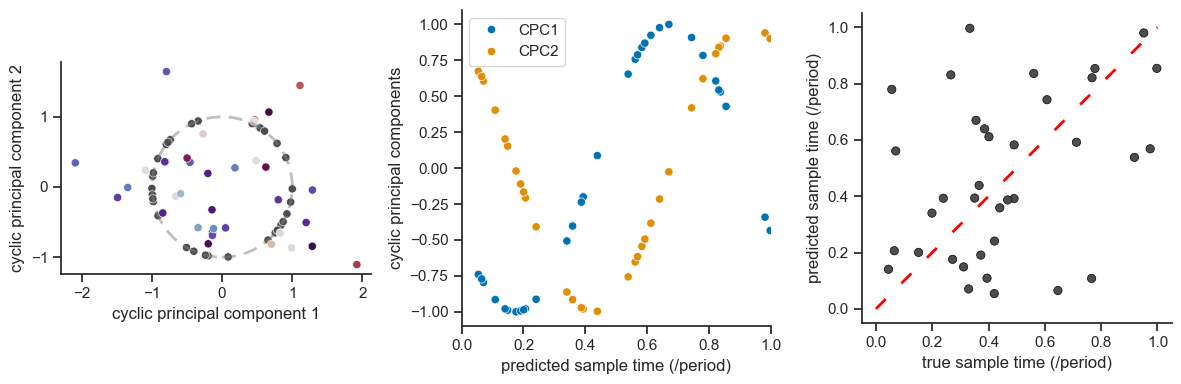

In [20]:
results_train_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=24)

In [21]:
results_train_b["MAPE"]*24

np.float64(3.7882733784103917)

### COFE Control Putamen

In [22]:
X_train_c = data_df_log[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Putamen')]
true_time_train_c = adata.var[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Putamen')]['time'].astype(float)

X_train_c, X_test_c, features_c, features_std_c = COFE.analyse.preprocess_data(X_train_c.to_numpy(), None, 
                                                                           features=X_train_c.columns, feature_dim='col', 
                                                                           mean_threshold= 0,scaling_threshold=4.5)
X_train_c.shape # (Samples, Transcripts)

(36, 7535)

In [23]:
s_choices = np.linspace(1, 50, 15)
cv_c = COFE.analyse.cross_validate(X_train_c, s_choices, features=features_c, K=5, ncores=-1, restarts=10)

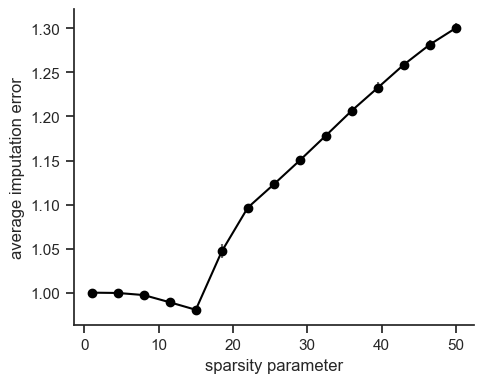

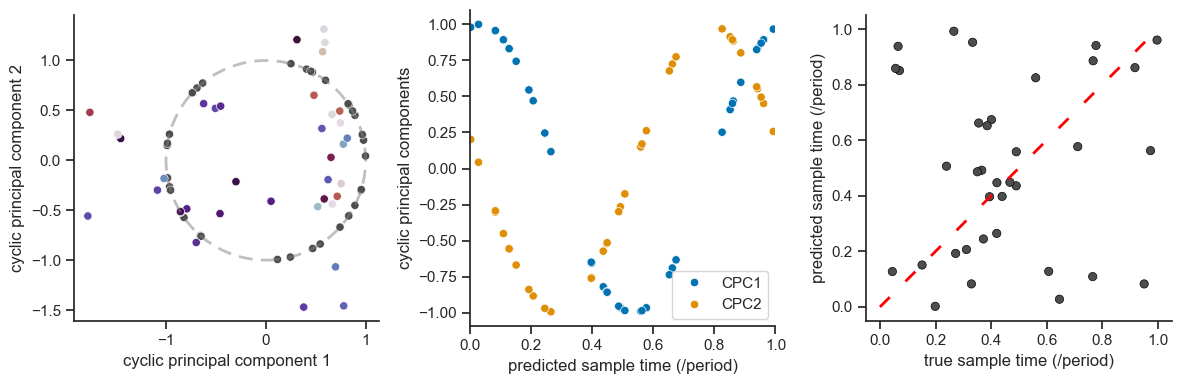

In [24]:
results_train_c = COFE.analyse.predict_time(X_train_c, cv_c, true_times=true_time_train_c.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_c, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_c, time=true_time_train_c.to_numpy(), X=X_train_c, figsize=(12, 4), period=24)

In [25]:
results_train_c["MAPE"]*24

np.float64(3.248827332946311)

### COFE Psychosis Nac

In [26]:
X_train_a = data_df_log[((adata.var['disease'] == 'psychosis_schizophrenia')|(adata.var['disease'] == 'psychosis_bipolar') )&(adata.var['tissue'] == 'Nac')]
true_time_train_a = adata.var[((adata.var['disease'] == 'psychosis_schizophrenia')|(adata.var['disease'] == 'psychosis_bipolar') )&(adata.var['tissue'] == 'Nac')]['time'].astype(float)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=0, scaling_threshold=4)
X_train_a.shape # (Samples, Transcripts)

(35, 6361)

In [27]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1, restarts=10)

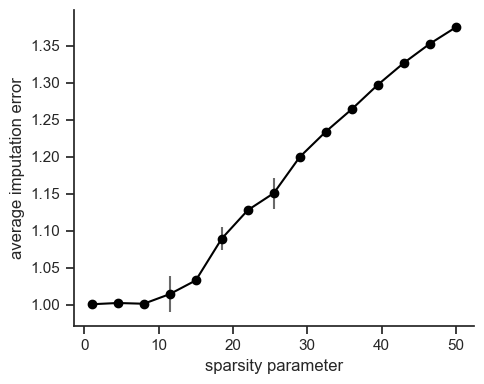

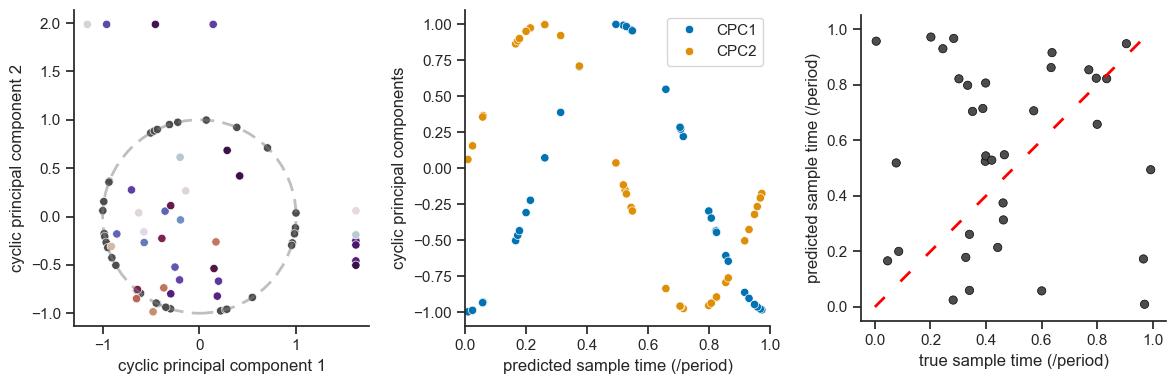

In [28]:
results_train_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=24)

In [29]:
results_train_a["MAPE"]*24

np.float64(3.584590179069018)

### COFE Psychosis Caudate

In [31]:
X_train_b = data_df_log[((adata.var['disease'] == 'psychosis_schizophrenia')|(adata.var['disease'] == 'psychosis_bipolar') )&(adata.var['tissue'] == 'Caudate')]
true_time_train_b = adata.var[((adata.var['disease'] == 'psychosis_schizophrenia')|(adata.var['disease'] == 'psychosis_bipolar') )&(adata.var['tissue'] == 'Caudate')]['time'].astype(float)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col', 
                                                                           mean_threshold= 1,scaling_threshold=7)
X_train_b.shape # (Samples, Transcripts)

(36, 7065)

In [32]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1, restarts = 10)

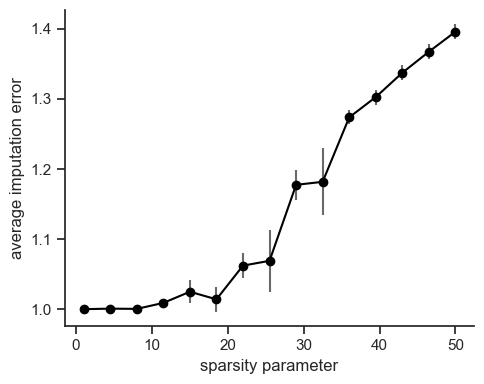

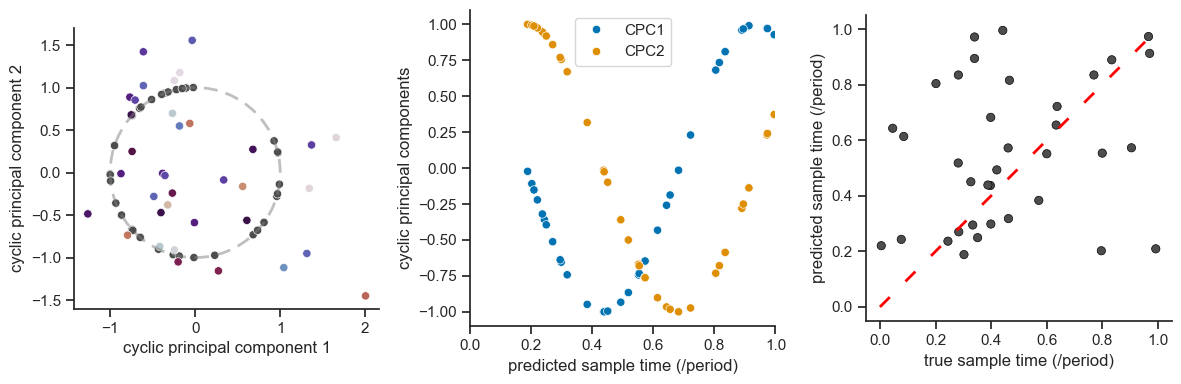

In [33]:
results_train_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=24)

In [34]:
results_train_b["MAPE"]*24

np.float64(3.2164804868768906)

### COFE Psychosis Putamen

In [36]:
X_train_c = data_df_log[((adata.var['disease'] == 'psychosis_schizophrenia')|(adata.var['disease'] == 'psychosis_bipolar') )&(adata.var['tissue'] == 'Putamen')]
true_time_train_c = adata.var[((adata.var['disease'] == 'psychosis_schizophrenia')|(adata.var['disease'] == 'psychosis_bipolar') )&(adata.var['tissue'] == 'Putamen')]['time'].astype(float)

X_train_c, X_test_c, features_c, features_std_c = COFE.analyse.preprocess_data(X_train_c.to_numpy(), None, 
                                                                           features=X_train_c.columns, feature_dim='col', 
                                                                           mean_threshold= 0,scaling_threshold=4)
X_train_c.shape # (Samples, Transcripts)

(36, 7157)

In [37]:
s_choices = np.linspace(1, 50, 15)
cv_c = COFE.analyse.cross_validate(X_train_c, s_choices, features=features_c, K=5, ncores=-1, restarts = 10)

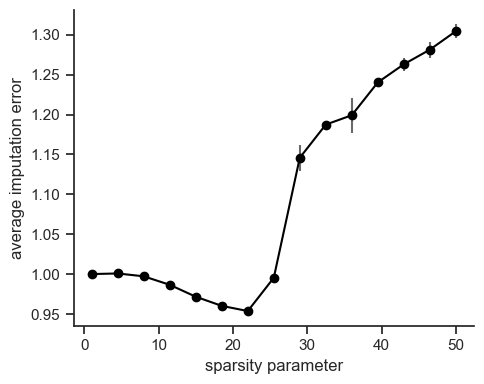

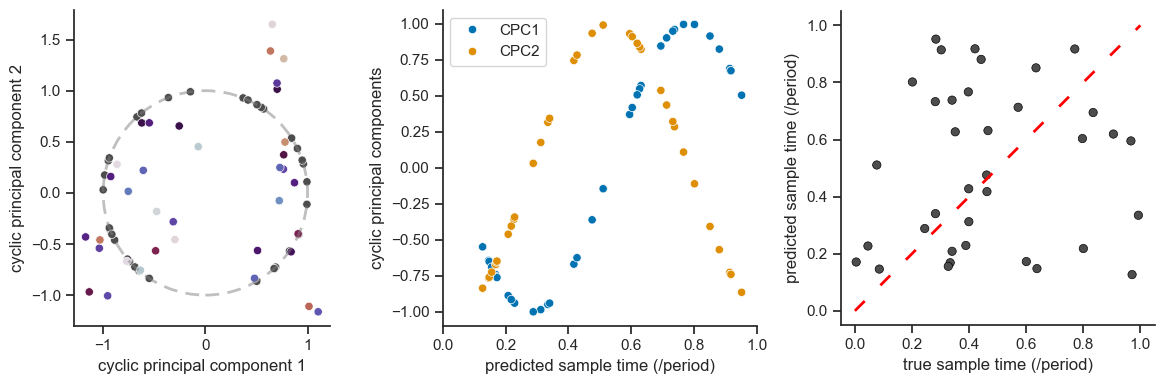

In [38]:
results_train_c = COFE.analyse.predict_time(X_train_c, cv_c, true_times=true_time_train_c.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_c, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_c, time=true_time_train_c.to_numpy(), X=X_train_c, figsize=(12, 4), period=24)

In [39]:
results_train_c["MAPE"]*24

np.float64(4.4993061493368325)

### COFE: Nac Control Batch Corrected

In [41]:
X_train_a = residual_5[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Nac')]
true_time_train_a = adata.var[(adata.var['disease'] == 'match control')&(adata.var['tissue'] == 'Nac')]['time'].astype(float)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=-1, scaling_threshold=6)
X_train_a.shape # (Samples, Transcripts)

(36, 7762)

In [42]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1, restarts=10)

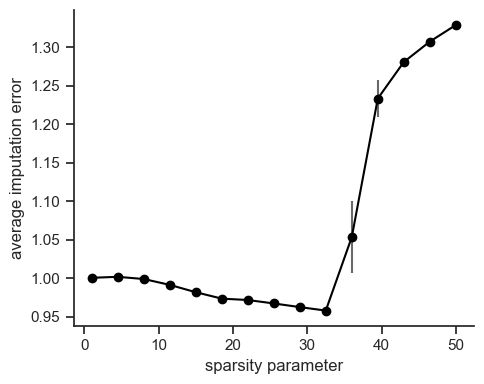

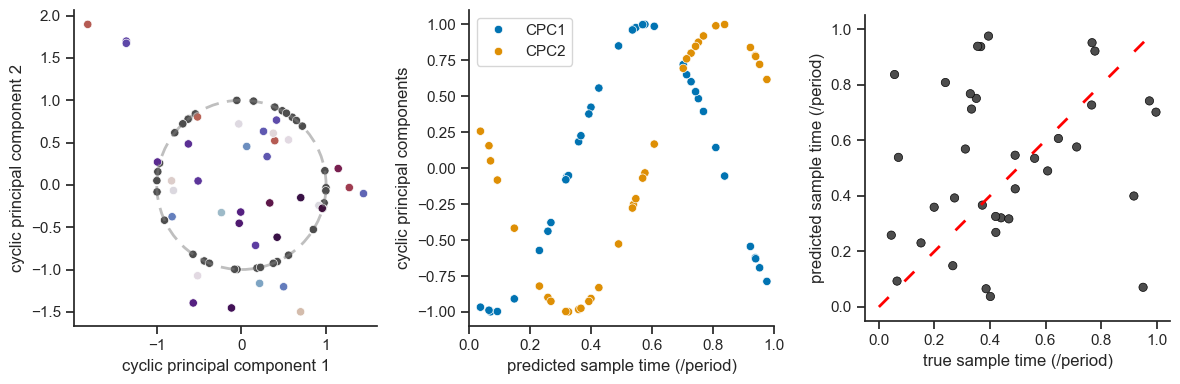

In [43]:
results_train_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=24)

In [44]:
results_train_a["MAPE"]*24

np.float64(3.7538031501739746)

## Conclusion 

COFE performs here as expected. The results in psychosis group is slightly worse then in control group, but regardles COFE's prediction power on this dataset isn't that great. However, the number of rhythmic genes in the brain regions aside the hypothalamus is quite low, and more samples per brain region are probably required to obtain a more meaningful result.
